# Machine Learning models on Mismatch Response data

In this notebook: 
- Necessary imports
- SVM model 
- Logistic Regression model
- Decision Tree model

## Imports

In [1]:
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
import seaborn as sn
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
#import initialization_functions #library to import data
import epod_helper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('df_avg_mmr.csv', sep = ',')
df

,Group_AccToParents,mean_AF3,mean_AF4,mean_C3,mean_C4,mean_CP1,mean_CP2,mean_CP5,mean_CP6,mean_Cz,...,var_P7,var_P8,var_PO3,var_PO4,var_Pz,var_T7,var_T8,ParticipantID,sex,age_months
0,1,-8.698850,-23.709517,-14.116824,-19.310100,-2.458536,-26.754174,-10.368958,-22.028517,-21.244704,...,136.716508,337.816997,384.993960,244.368925,200.547652,113.608744,355.856014,101,1,20
1,0,-12.651143,-17.591247,-14.895518,-10.553126,-3.815776,-4.456747,-7.756276,-1.770537,-11.983060,...,1213.374987,541.131597,602.439210,497.709783,576.354850,546.263357,320.299078,102,0,20
2,1,-4.291754,-7.721236,-25.840885,-21.765084,-33.959699,-34.063565,-32.614270,-16.372054,-33.627666,...,303.998905,496.661763,867.650545,797.421991,567.904304,337.769169,302.277737,103,0,20
3,1,-23.586452,-27.014460,-14.197314,-12.797756,-19.694582,-19.994248,-11.238579,-6.616907,-27.799114,...,183.609953,131.355955,111.983206,172.833291,138.677103,154.772343,95.081613,104,1,18
4,1,-3.473711,-2.229290,0.588515,-0.464928,7.717058,11.191306,2.232668,0.528495,9.460590,...,137.164369,404.895588,257.591693,387.939507,203.877964,145.847537,77.076837,105,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0,-41.444634,-25.633972,-32.105548,-50.839191,-46.723724,-29.315308,-4.623241,-19.818626,-37.566254,...,231.381299,112.791440,1384.341960,1315.873799,1741.909484,182.765358,1221.561377,216,0,18
86,1,1.937432,14.313379,-0.034367,14.749652,2.544271,13.065405,5.469382,25.247935,6.492388,...,171.277159,173.994679,213.585422,252.498077,217.125857,235.590776,436.839069,217,0,18
87,0,4.080161,7.790090,-3.307886,-5.131242,-1.775464,-3.360262,-3.148090,-4.764215,5.065358,...,106.152805,94.708524,96.529695,277.776943,236.351164,79.117091,117.409253,218,1,18
88,1,0.307460,-3.515791,-5.737908,-7.957848,-4.395491,-4.698619,-26.413288,-28.337591,12.101671,...,540.599299,347.410313,565.697081,1417.416897,787.046765,256.082444,476.147113,219,1,18


In [3]:
features_of_interest = df[['mean_AF3',
 'mean_F3',
 'mean_F7',
 'mean_FC1',
 'mean_FC5',
 'mean_Fp1',
 'mean_Fz',
 'kurt_AF3',
 'kurt_F3',
 'kurt_F7',
 'kurt_FC1',
 'kurt_FC5',
 'kurt_Fp1',
 'kurt_Fz',
 'skew_AF3',
 'skew_F3',
 'skew_F7',
 'skew_FC1',
 'skew_FC5',
 'skew_Fp1',
 'skew_Fz',
 'std_AF3',
 'std_F3',
 'std_F7',
 'std_FC1',
 'std_FC5',
 'std_Fp1',
 'std_Fz',
 'var_AF3',
 'var_F3',
 'var_F7',
 'var_FC1',
 'var_FC5',
 'var_Fp1',
 'var_Fz',
 'sex',
 'age_months']]

In [4]:
dfcor = features_of_interest.corr()

In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dfcor, 50))

Top Absolute Correlations
std_F7    var_F7      0.997228
std_Fp1   var_Fp1     0.996287
std_AF3   var_AF3     0.995789
          var_Fp1     0.993066
var_AF3   var_Fp1     0.990742
std_AF3   std_Fp1     0.990281
var_F7    var_Fp1     0.982833
std_Fp1   var_AF3     0.981334
std_F7    var_Fp1     0.979941
std_AF3   var_F7      0.978727
std_F7    std_Fp1     0.978676
std_AF3   std_F7      0.978252
mean_AF3  mean_Fp1    0.978015
std_Fp1   var_F7      0.976693
var_AF3   var_F7      0.972226
std_Fz    var_Fz      0.970169
skew_AF3  skew_Fp1    0.967476
std_F7    var_AF3     0.966277
kurt_AF3  kurt_F3     0.960785
mean_F7   mean_Fp1    0.955811
std_FC1   var_FC1     0.955094
kurt_AF3  kurt_Fp1    0.953951
std_FC5   var_FC5     0.953057
skew_AF3  skew_F3     0.940782
          skew_Fz     0.929873
skew_F3   skew_Fz     0.928349
std_F3    var_F3      0.927506
kurt_F3   kurt_Fz     0.921227
          kurt_Fp1    0.919525
mean_AF3  mean_F7     0.917998
skew_AF3  skew_F7     0.915753
mean_FC1  var

## Split data

In [27]:
y = df['Group_AccToParents'].values # dependant variable
X = df[['mean_AF3',
 'mean_F3',
 'mean_F7',
 'mean_FC1',
 'mean_FC5',
 'mean_Fp1',
 'mean_Fz',
 'kurt_AF3',
 'kurt_F3',
 'kurt_F7',
 'kurt_FC1',
 'kurt_FC5',
 'kurt_Fp1',
 'kurt_Fz',
 'skew_AF3',
 'skew_F3',
 'skew_F7',
 'skew_FC1',
 'skew_FC5',
 'skew_Fp1',
 'skew_Fz',
 'std_AF3',
 'std_F3',
 'std_F7',
 'std_FC1',
 'std_FC5',
 'std_Fp1',
 'std_Fz',
 'sex',
 'age_months']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Scale data

In [28]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [29]:
#pca = PCA()
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)

## SVM model

In [30]:
svm = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 10]}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train, y_train)

sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [31]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

In [32]:
clf.score(X_train, y_train)

1.0

In [33]:
svm = SVC(C=0.1, kernel='linear')
svm.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [34]:
y_pred = svm.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.667


In [35]:
y_pred

array([1, 1, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

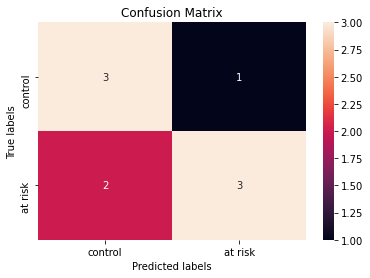

In [36]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

## Logistic Regression model

In [37]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [38]:
y_pred = lr.predict(X_test)

In [39]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.667


In [40]:
y_pred

array([1, 1, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

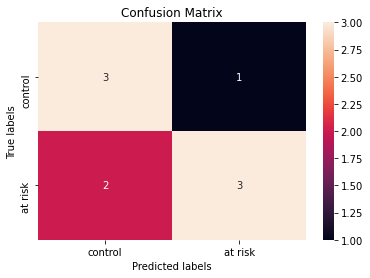

In [41]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

## Decision Tree model

In [42]:
dt = tree.DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [43]:
y_pred = dt.predict(X_test)

In [44]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.444


In [45]:
y_pred

array([0, 1, 1, 1, 0, 0, 0, 0, 1], dtype=int64)

[Text(217.62, 205.35999999999999, 'X[0] <= 0.673\ngini = 0.498\nsamples = 81\nvalue = [38, 43]'),
 Text(145.08, 181.2, 'X[3] <= 0.086\ngini = 0.486\nsamples = 72\nvalue = [30, 42]'),
 Text(66.96000000000001, 157.04, 'X[18] <= -0.513\ngini = 0.48\nsamples = 35\nvalue = [21, 14]'),
 Text(44.64, 132.88, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(89.28, 132.88, 'X[11] <= 1.389\ngini = 0.499\nsamples = 27\nvalue = [13, 14]'),
 Text(66.96000000000001, 108.72, 'X[5] <= -0.422\ngini = 0.463\nsamples = 22\nvalue = [8, 14]'),
 Text(44.64, 84.56, 'X[19] <= -0.138\ngini = 0.49\nsamples = 14\nvalue = [8, 6]'),
 Text(22.32, 60.400000000000006, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(66.96000000000001, 60.400000000000006, 'X[10] <= 0.347\ngini = 0.32\nsamples = 10\nvalue = [8, 2]'),
 Text(44.64, 36.24000000000001, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(89.28, 36.24000000000001, 'X[25] <= 0.359\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(66.96000000000001, 12.079999

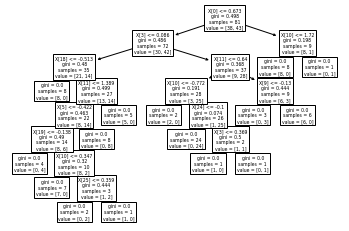

In [46]:
tree.plot_tree(dt)

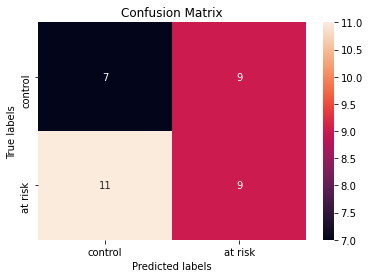

In [26]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);